In [1]:
import os
import sys
import datetime
import random
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import recmetrics
import ml_metrics
import seaborn as sns


In [2]:
random.seed(0)
%matplotlib inline
sys.path.append('../utils/')

In [3]:
from content_based_recomender import ContentBasedRecommender
from collaborative_filtering_matrix_factorization import CFRecommender
from baseline_last_sold_recommender import LastSoldRecommender
from baseline_most_sold_recommender import MostSoldRecommender
from modeling_utils import fill_with_other_items_randomly, get_sales_until_date

# Load data

In [4]:
for dirname, _, filenames in os.walk('./../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./../data/Customer.csv
./../data/prod_cat_info.csv
./../data/Transactions.csv


In [5]:
prod_cat_info_raw_df = pd.read_csv('./../data/prod_cat_info.csv')
transactions_raw_df = pd.read_csv('./../data/Transactions.csv')


In [6]:
transactions_raw_df['tran_date'] = pd.to_datetime(transactions_raw_df['tran_date'].str.replace('/','-'), format='%d-%m-%Y')
transactions_raw_df.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop


In [7]:
transactions_df = transactions_raw_df.copy()
transactions_df = transactions_df[transactions_df.Qty>0]
transactions_df['item_id'] = transactions_df.prod_cat_code.astype(str) + '_' + transactions_df.prod_subcat_code.astype(str)
transactions_df = transactions_df[['transaction_id', 'cust_id', 'item_id', 'tran_date', 'Qty']]
transactions_df

,transaction_id,cust_id,item_id,tran_date,Qty
10,29258453508,270384,3_5,2014-02-20,5
11,25455265351,267750,6_12,2014-02-20,3
12,1571002198,275023,5_6,2014-02-20,4
14,36554696014,269345,5_3,2014-02-20,3
15,56814940239,268799,5_7,2014-02-20,5
...,...,...,...,...,...
23048,94340757522,274550,5_12,2011-01-25,1
23049,89780862956,270022,1_4,2011-01-25,1
23050,85115299378,271020,6_2,2011-01-25,4
23051,72870271171,270911,5_11,2011-01-25,3


# Recommendation : formulating the problem

## Items table

L'ID d'un 'item' sera la concaténation de la catégorie et de la sous catégorie

In [8]:
items_df = prod_cat_info_raw_df.copy()
items_df['item_id'] = items_df.prod_cat_code.astype(str) + '_' + items_df.prod_sub_cat_code.astype(str)
items_df = items_df[['item_id','prod_cat_code', 'prod_cat', 'prod_sub_cat_code', 'prod_subcat']]
items_df

,item_id,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1_4,1,Clothing,4,Mens
1,1_1,1,Clothing,1,Women
2,1_3,1,Clothing,3,Kids
3,2_1,2,Footwear,1,Mens
4,2_3,2,Footwear,3,Women
5,2_4,2,Footwear,4,Kids
6,3_4,3,Electronics,4,Mobiles
7,3_5,3,Electronics,5,Computers
8,3_8,3,Electronics,8,Personal Appliances
9,3_9,3,Electronics,9,Cameras


In [9]:
items_df[['item_id','prod_cat','prod_subcat']]

,item_id,prod_cat,prod_subcat
0,1_4,Clothing,Mens
1,1_1,Clothing,Women
2,1_3,Clothing,Kids
3,2_1,Footwear,Mens
4,2_3,Footwear,Women
5,2_4,Footwear,Kids
6,3_4,Electronics,Mobiles
7,3_5,Electronics,Computers
8,3_8,Electronics,Personal Appliances
9,3_9,Electronics,Cameras


In [10]:
items_df['dummy_column'] = 1

prod_cat_features = pd.pivot_table(items_df, index='item_id', columns='prod_cat', values='dummy_column')
prod_subcat_features = pd.pivot_table(items_df, index='item_id', columns='prod_subcat', values='dummy_column')

prod_features = prod_cat_features.join(prod_subcat_features).fillna(0)

items_df.drop(columns=['dummy_column'], inplace=True)


In [11]:
example_date = '01-04-2011'
sales = get_sales_until_date(transactions_df, example_date)
sales

,1_1,1_3,1_4,2_1,2_3,2_4,3_10,3_4,3_5,3_8,...,5_10,5_11,5_12,5_3,5_6,5_7,6_10,6_11,6_12,6_2
cust_id,,,,,,,,,,,,,,,,,,,,,
266785,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266794,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266810,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275224,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
275226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Build and evaluate the model:

We evaluate it on the year 2013 (training on 2011-2012)
We make predictions every month

In [12]:
dates_to_train_on = [f'01-{str(month).zfill(2)}-2013' for month in range(1,13)]+['01-01-2014']

In [13]:
items_ids = items_df.item_id.unique()
local_fill_with_other_items_randomly = lambda x: fill_with_other_items_randomly(x, items_ids)


In [14]:
def recall_at_k(items_sold: List[List[str]], items_predicted: List[List[str]]):
    """
    Mean (Size(item |  item in items_sold and item in items_predicted) / Size(item |  item in items_sold) for each user) 
    :param items_sold: array-like, List of users' lists of items sold 
    :param items_predicted: array-like, List of users' lists of recommended items 
    :return:
    """
    return sum([len(set(x) & set(y)) / len(x) for x, y in zip(items_sold, items_predicted)]) / len(items_sold)

def precision_at_k(items_sold: List[List[str]], items_predicted: List[List[str]]):
    """
    Mean (Size(item |  item in items_sold and item in items_predicted) / Size(item |  item in items_predicted) for each user) 
    :param items_sold: array-like, List of users' lists of items sold 
    :param items_predicted: array-like, List of users' lists of recommended items 
    :return:
    """
    return sum([len(set(x) & set(y)) / len(y) for x, y in zip(items_sold, items_predicted)]) / len(items_sold)

def coverage_at_k( items_predicted: List[List[str]]):
    """
    Number of items ever recommended / number of items 
    :param items_predicted: array-like, List of users' lists of recommended items 
    :return:
    """
    recommended_items_set = set()
    for recommendation in items_predicted:
        recommended_items_set |= set(recommendation)
    return len(recommended_items_set)/len(items_df)
def novelty_at_k(items_previously_sold: List[List[str]], items_predicted: List[List[str]]):
    """
    Novelty metric 
    :param items_predicted: array-like, List of users' lists of recommended items 
    :return:
    """
    return sum([len(set(y) - set(x)) / len(y) for x, y in zip(items_previously_sold, items_predicted)]) / len(items_previously_sold)


#### Baselines and content-based recommender

In [15]:
    yearly_sold = []
    yearly_previously_sold = []
    yearly_cbr_predictions = []
    yearly_lsr_predictions = []
    yearly_msr_predictions = []


    for i, date in enumerate(dates_to_train_on[:-1]):

        cumulative_sales = get_sales_until_date(transactions_df, date)

        cumulative_sales_next_month = get_sales_until_date(transactions_df, dates_to_train_on[i+1])
        sales_next_month = (cumulative_sales_next_month - cumulative_sales).fillna(0)
        total_sales_next_month = sales_next_month.sum(axis=1)
        customers_next_month = total_sales_next_month[total_sales_next_month > 0].index.tolist()

        items_sold = sales_next_month.loc[customers_next_month].apply(lambda s : s[s > 0].index.tolist(), axis=1)
        yearly_sold.append(items_sold)
        
        #create previously sold
        full_cumulative_sales = cumulative_sales.copy()
        for x in customers_next_month:
            if x not in full_cumulative_sales.index:
                full_cumulative_sales.loc[x]=0
        items_previously_sold = full_cumulative_sales.loc[customers_next_month].apply(lambda s : s[s > 0].index.tolist(), axis=1)
        yearly_previously_sold.append(items_previously_sold)
        
        

        # Content based recommender
        cbr = ContentBasedRecommender(prod_features.columns)
        cbr.fit(cumulative_sales, prod_features)
        predictions = cbr.predict(customers_next_month)
        cbr_predicted_items = (predictions
                               .apply(lambda s: s[s > 0].sort_values(ascending=False).index.tolist(), axis=1)
                               .map(local_fill_with_other_items_randomly)
        )
        yearly_cbr_predictions.append(cbr_predicted_items)

        # Last sold recommender 
        transaction_until_current_month = transactions_df[transactions_df.tran_date < pd.to_datetime(date, format='%d-%m-%Y')]
        lsr = LastSoldRecommender()
        lsr.fit(transaction_until_current_month)
        lsr_predicted_items = lsr.predict(customers_next_month).map(local_fill_with_other_items_randomly)
        yearly_lsr_predictions.append(lsr_predicted_items)

        # Most sold recommender 
        msr = MostSoldRecommender()
        msr.fit(cumulative_sales)
        msr_predicted_items = msr.predict(customers_next_month).map(local_fill_with_other_items_randomly)
        yearly_msr_predictions.append(msr_predicted_items)

    yearly_sold = pd.concat(yearly_sold, ignore_index=True)
    yearly_previously_sold = pd.concat(yearly_previously_sold, ignore_index=True)
    yearly_cbr_predictions = pd.concat(yearly_cbr_predictions, ignore_index=True)
    yearly_lsr_predictions = pd.concat(yearly_lsr_predictions, ignore_index=True)
    yearly_msr_predictions = pd.concat(yearly_msr_predictions, ignore_index=True)
    


#### Colaborative filtering recommender

In [16]:
    yearly_cfr_predictions = []


    for i, date in enumerate(dates_to_train_on[:-1]):

        cumulative_sales = get_sales_until_date(transactions_df, date, False)

        cumulative_sales_next_month = get_sales_until_date(transactions_df, dates_to_train_on[i+1]).fillna(0)
        sales_next_month = (cumulative_sales_next_month-cumulative_sales.fillna(0)).fillna(0)
        total_sales_next_month = sales_next_month.sum(axis=1)
        customers_next_month = total_sales_next_month[total_sales_next_month>0].index.tolist()

        items_sold = sales_next_month.loc[customers_next_month].apply(lambda s : s[s>0].index.tolist(),axis=1)
        yearly_sold.append(items_sold)

        #create previously sold
        full_cumulative_sales = cumulative_sales.fillna(0).copy()
        for x in customers_next_month:
            if x not in full_cumulative_sales.index:
                full_cumulative_sales.loc[x]=0
        items_previously_sold = full_cumulative_sales.loc[customers_next_month].apply(lambda s : s[s > 0].index.tolist(), axis=1)
        yearly_previously_sold.append(items_previously_sold)
        # Content based recommender
        cfr = CFRecommender(factors=7, iterations=5, random_state=0, calculate_training_loss=True)
        cfr.fit(cumulative_sales)
        predictions = cfr.predict(customers_next_month)
        cfr_predicted_items = (predictions
                               .apply(lambda s : s[s>0].sort_values(ascending=False).index.tolist(),axis=1)
                               .map(local_fill_with_other_items_randomly)
        )
        yearly_cfr_predictions.append(cfr_predicted_items)


    yearly_cfr_predictions = pd.concat(yearly_cfr_predictions,ignore_index=True)


#### Evaluation metrics

In [17]:
ks = list(range(1,24))


In [18]:
predictions = [yearly_cbr_predictions, yearly_cfr_predictions, yearly_msr_predictions, yearly_lsr_predictions]

In [19]:
novelty_at_k_scores = [[novelty_at_k(yearly_previously_sold, preds.map(lambda x : x[:k])) for k in ks] for preds in predictions]
recall_at_k_scores = [[recall_at_k(yearly_sold, preds.map(lambda x : x[:k])) for k in ks] for preds in predictions]
precision_at_k_scores = [[precision_at_k(yearly_sold, preds.map(lambda x : x[:k])) for k in ks] for preds in predictions]
mean_average_recall_at_k_scores = [[recmetrics.metrics.mark(yearly_sold, preds, k=k) for k in ks] for preds in predictions]
mean_average_precision_at_k_scores = [[ml_metrics.mapk(yearly_sold, preds, k=k) for k in ks] for preds in predictions]


In [20]:
sns.set_theme("paper", font_scale=1.5)
legend = ['Content-based','Collaborative-filtering','Most Sold','Last Sold']

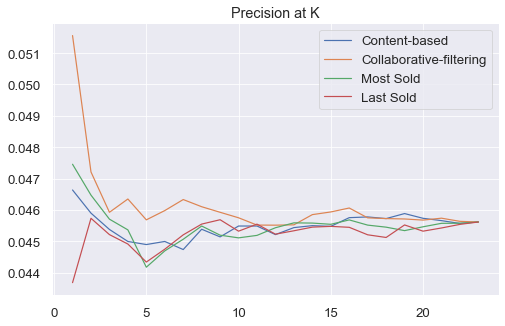

In [21]:
plt.figure(figsize=(8,5))
for pak in precision_at_k_scores:
    plt.plot(ks,pak)
plt.legend(legend)
plt.title('Precision at K')
plt.show()

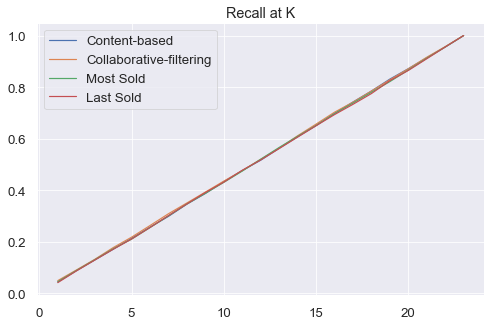

In [22]:
plt.figure(figsize=(8,5))
for rak in recall_at_k_scores:
    plt.plot(ks,rak)
plt.legend(legend)
plt.title('Recall at K')
plt.show()

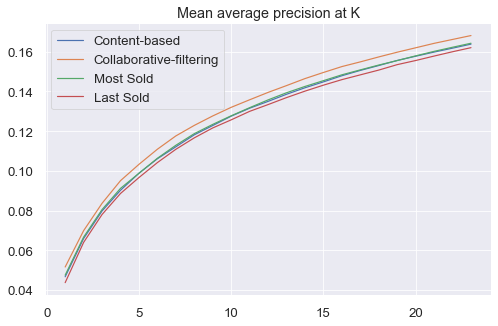

In [23]:
plt.figure(figsize=(8,5))
for mapk in mean_average_precision_at_k_scores:
    plt.plot(ks,mapk)
plt.legend(legend)
plt.title('Mean average precision at K')
plt.show()

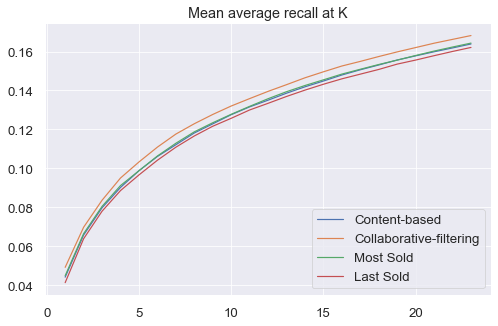

In [24]:
plt.figure(figsize=(8,5))
for mark in mean_average_recall_at_k_scores:
    plt.plot(ks,mark)
plt.legend(legend)
plt.title('Mean average recall at K')
plt.show()

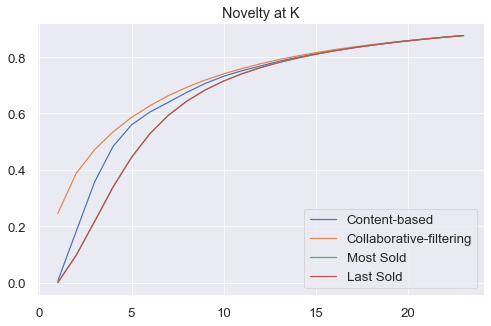

In [25]:
plt.figure(figsize=(8,5))
for nak in novelty_at_k_scores:
    plt.plot(ks,nak)
plt.legend(legend)
plt.title('Novelty at K')
plt.show()